In [24]:
# Cell 1: Install Dependencies
# Run this cell once
!pip install jupyter ipykernel pymupdf sentence-transformers scikit-learn hdbscan umap-learn matplotlib pytesseract


In [25]:
# Cell 2: Import Libraries
import fitz  # PyMuPDF
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan
import umap
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image


In [26]:
# Cell 3: Extract Pages from PDF
# This function extracts text from each page, with OCR fallback for empty pages

def extract_pages(pdf_path):
    doc = fitz.open(pdf_path)
    pages = []
    for i, page in enumerate(doc):
        text = page.get_text("text").strip()
        if text:
            pages.append({"page": i, "text": text})
        else:
            # Fallback OCR
            pix = page.get_pixmap()
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            text = pytesseract.image_to_string(img)
            pages.append({"page": i, "text": text if text.strip() else "[EMPTY]"})
    return pages

# Example usage
pdf_path = "merged doc.pdf"
pages = extract_pages(pdf_path)
print(f"Total pages extracted: {len(pages)}")
print(pages[0])


Total pages extracted: 13
{'page': 0, 'text': "LOAN #410,\nBORROWER'S CERTIFICATION & AUTHORIZATION\n\n‘ertfeaton\n\n‘Tre undergrad cent tow\n1 UWenav sped ora manga ln tom we\n\n‘tendon,\n‘hatanbuttand sauce oe don ayes, elon snd ness rma an Ses sabes TG\nSenile svar eames ne mapas ean 3c\n\n2 he wanda one a Lar case gh hang re merge an mda ces ul\n‘eum pagan ray ache mvog fe Rornson favaev or appr wh He eee!\n\nAit andar  Fesara cme punshatie ye or morsaumen of who knowin make any\n\ni ters ton savages appear bu ona 8 Ua a ot,\n\n-Authorintion to Release Itormation\n\n1 We have app a morgage ln Hom Lande As pa oe epseaten pcess. Lande! andthe mage\n‘csontcton sh he an athe ore he aan Gesadr a pattott qaty contd gars\n2. i aumere yuo roa anda and ay veto wham Loner ay cy agaoe. Ad he\nImogene’ ay ae ah isnaan ans Socrates Sac ro\nIndeed, engl ta arinarebr, ney maa ads a are\n‘Sar arrest parca gage emerge ray ary) may es i\n3imeneaiantc arpa raed ne ar\n£2'Suy aims aureaton maybe sep a

In [27]:
# Cell 4: Generate Embeddings for Each Page
# Using Sentence-BERT (no API key required)
model = SentenceTransformer("all-MiniLM-L6-v2")
page_texts = [p["text"] for p in pages]
embeddings = model.encode(page_texts, show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Cell 5: Compute Similarity Between Consecutive Pages
similarity_scores = [cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0] 
                     for i in range(len(embeddings)-1)]

print("Similarity scores between consecutive pages:")
print(similarity_scores)


Similarity scores between consecutive pages:
[0.46922922, 0.050562233, 0.42374673, 0.8765278, 0.8945304, -0.047792178, 0.19815254, 0.0820862, 0.8573452, 0.91716075, -0.041431166, 0.4565196]


In [29]:
# Enhanced Document Boundary Detection (Improved Version)
import re
import numpy as np

def detect_document_boundaries_enhanced_v2(pages, embeddings, similarity_scores, min_page_gap=2, verbose=True):
    """
    Detect document boundaries using:
    - Semantic similarity between consecutive pages
    - Content patterns (titles, signatures, headers, word count, dates)
    """
    boundaries = [0]  # first page always a boundary
    
    # Adaptive similarity threshold
    sim_mean = np.mean(similarity_scores)
    sim_std = np.std(similarity_scores)
    adaptive_threshold = max(sim_mean - 0.5 * sim_std, 0.3)  # lower cap for very low sim
    
    if verbose:
        print(f"Adaptive similarity threshold: {adaptive_threshold:.3f}")
    
    # Extract page features
    page_features = []
    for page in pages:
        text = page['text'].lower()
        features = {
            'title_pattern': bool(re.search(r'^[A-Z\s]{5,}', page['text'])),
            'page_number': bool(re.search(r'page\s*\d+|\d+\s*of\s*\d+', text)),
            'header_footer': bool(re.search(r'(header|footer|copyright|confidential)', text)),
            'word_count': len(text.split()),
            'line_count': len([line for line in text.split('\n') if line.strip()]),
            'signature': bool(re.search(r'(signature|signed|regards|sincerely)', text)),
            'date': bool(re.search(r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2}', text))
        }
        page_features.append(features)
    
    last_boundary = 0
    
    # Detect boundaries
    for i, sim in enumerate(similarity_scores):
        page_num = i + 1  # next page index
        
        # Skip if too close to last boundary
        if page_num - last_boundary < min_page_gap:
            continue
        
        # Similarity drop indicator
        similarity_drop = sim < adaptive_threshold
        
        # Content-based indicators (weighted)
        current = page_features[page_num]
        prev = page_features[i]
        score = 0
        
        if current['title_pattern']:
            score += 2  # strong indicator
        if current['word_count'] < 50:
            score += 1
        if prev['signature']:
            score += 1
        if abs(current['word_count'] - prev['word_count']) > 100:
            score += 1
        if current['date']:
            score += 0.5
        if current['header_footer']:
            score += 0.5
        
        # Decision threshold
        if similarity_drop or score >= 2:
            boundaries.append(page_num)
            last_boundary = page_num
            if verbose:
                print(f"Boundary at page {page_num} | sim={sim:.3f}, score={score}")
    
    boundaries.append(len(pages))
    return boundaries

# Apply the improved detection
enhanced_boundaries_v2 = detect_document_boundaries_enhanced_v2(pages, embeddings, similarity_scores)
print("Enhanced document boundaries v2 (page indices):", enhanced_boundaries_v2)


Adaptive similarity threshold: 0.300
Boundary at page 2 | sim=0.051, score=2.5
Boundary at page 6 | sim=-0.048, score=2
Boundary at page 8 | sim=0.082, score=1.5
Boundary at page 11 | sim=-0.041, score=2
Enhanced document boundaries v2 (page indices): [0, 2, 6, 8, 11, 13]


In [ ]:
# Cell 7: Group Pages into Documents with Enhanced Detection
enhanced_documents = []
for i in range(len(enhanced_boundaries)-1):
    start, end = enhanced_boundaries[i], enhanced_boundaries[i+1]
    doc_pages = list(range(start, end))
    
    # Analyze document content for better naming
    doc_text = " ".join([pages[p]["text"] for p in doc_pages[:3]])  # First 3 pages
    doc_type = "Unknown"
    
    # Simple document type detection
    if re.search(r'(contract|agreement|terms)', doc_text.lower()):
        doc_type = "Contract"
    elif re.search(r'(invoice|bill|payment|amount)', doc_text.lower()):
        doc_type = "Invoice"
    elif re.search(r'(report|analysis|summary)', doc_text.lower()):
        doc_type = "Report"
    elif re.search(r'(letter|dear|regards)', doc_text.lower()):
        doc_type = "Letter"
    elif re.search(r'(manual|guide|instruction)', doc_text.lower()):
        doc_type = "Manual"
    
    enhanced_documents.append({
        "doc_id": i, 
        "pages": doc_pages,
        "page_count": len(doc_pages),
        "type": doc_type,
        "start_page": start + 1,  # Human readable page numbers
        "end_page": end
    })

print("Enhanced documents detected:")
for doc in enhanced_documents:
    print(f"Document {doc['doc_id']}: {doc['type']} - Pages {doc['start_page']}-{doc['end_page']} ({doc['page_count']} pages)")
    
# Show preview of each document's first page
print("\nDocument previews (first 200 characters):")
for doc in enhanced_documents:
    first_page_text = pages[doc['pages'][0]]['text']
    preview = first_page_text[:200].replace('\n', ' ')
    print(f"Doc {doc['doc_id']} ({doc['type']}): {preview}...")

Enhanced documents detected:
Document 0: Unknown - Pages 1-1 (1 pages)
Document 1: Unknown - Pages 2-2 (1 pages)
Document 2: Letter - Pages 3-6 (4 pages)
Document 3: Unknown - Pages 7-7 (1 pages)
Document 4: Unknown - Pages 8-8 (1 pages)
Document 5: Report - Pages 9-11 (3 pages)
Document 6: Unknown - Pages 12-13 (2 pages)

Document previews (first 200 characters):
Doc 0 (Unknown): LOAN #410, BORROWER'S CERTIFICATION & AUTHORIZATION  ‘ertfeaton  ‘Tre undergrad cent tow 1 UWenav sped ora manga ln tom we  ‘tendon, ‘hatanbuttand sauce oe don ayes, elon snd ness rma an Ses sabes TG ...
Doc 1 (Unknown): SIGNATURE ADDENDUM  Le consent ome wet be nna ree yu er any srs relat le rigraten sang ae  ‘hibaeoceunon't uch came ee lenarsroce and BK Noe ae "an Ay een lm at  Signed By : John Homeowner we  ...
Doc 2 (Letter): Social Security Administration Supplemental Security Income Important Information  oe  fags Ww OUTER DRIVE. DEARRORN MP aela4 Prone: (31 2788150 Date: May 18, 2009,  Jha Homeowner CC

In [31]:
# Cell 8: Optional - Cluster Pages for Document Type Discovery
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
page_clusters = clusterer.fit_predict(embeddings)

# Sequence smoothing: merge consecutive pages with same cluster
refined_docs = []
current_cluster = page_clusters[0]
current_pages = [0]

for i, cluster in enumerate(page_clusters[1:], start=1):
    if cluster == current_cluster:
        current_pages.append(i)
    else:
        refined_docs.append({"cluster": current_cluster, "pages": current_pages})
        current_cluster = cluster
        current_pages = [i]

refined_docs.append({"cluster": current_cluster, "pages": current_pages})

print("Refined document grouping by clusters:")
for doc in refined_docs:
    print(doc)


Refined document grouping by clusters:
{'cluster': 0, 'pages': [0, 1]}
{'cluster': 1, 'pages': [2, 3, 4, 5]}
{'cluster': -1, 'pages': [6]}
{'cluster': 0, 'pages': [7]}
{'cluster': 1, 'pages': [8, 9, 10]}
{'cluster': 0, 'pages': [11, 12]}


c:\Users\mpawa\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mpawa\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


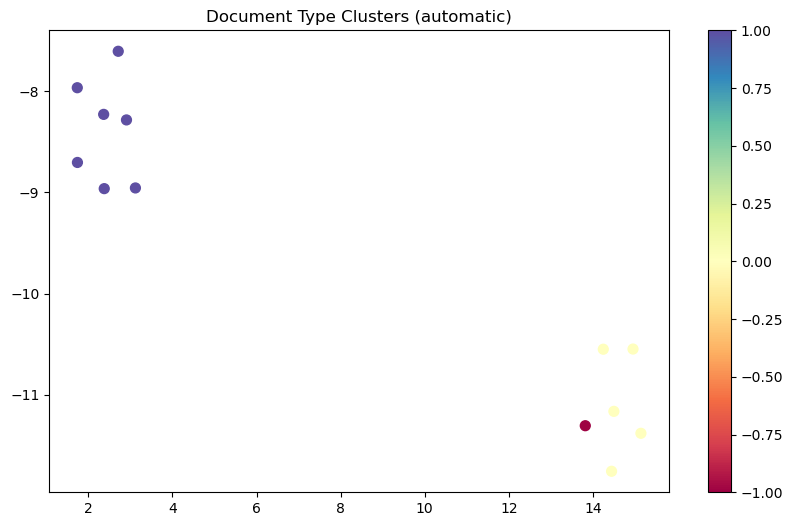

In [32]:
# Cell 9: Optional - Visualize Clusters
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10,6))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=page_clusters, cmap="Spectral", s=50)
plt.colorbar()
plt.title("Document Type Clusters (automatic)")
plt.show()


In [33]:
# Cell 10: Enhanced Save Function with Better Naming
def save_enhanced_documents(pdf_path, documents):
    doc = fitz.open(pdf_path)
    saved_files = []
    
    for d in documents:
        new_pdf = fitz.open()
        for page_num in d["pages"]:
            new_pdf.insert_pdf(doc, from_page=page_num, to_page=page_num)
        
        # Create descriptive filename
        filename = f"document_{d['doc_id']}_{d['type']}_pages_{d['start_page']}-{d['end_page']}.pdf"
        new_pdf.save(filename)
        new_pdf.close()
        saved_files.append(filename)
        
        print(f"Saved: {filename}")
    
    doc.close()
    return saved_files

# Save enhanced documents with better naming
print("Saving separated documents...")
saved_files = save_enhanced_documents(pdf_path, enhanced_documents)

print(f"\nSuccessfully separated into {len(saved_files)} documents:")
for filename in saved_files:
    print(f"- {filename}")

# Additional verification step
print("\nDocument separation summary:")
total_original_pages = len(pages)
total_extracted_pages = sum(doc['page_count'] for doc in enhanced_documents)
print(f"Original PDF pages: {total_original_pages}")
print(f"Extracted pages: {total_extracted_pages}")
print(f"Verification: {'✓ Success' if total_original_pages == total_extracted_pages else '✗ Page count mismatch'}")

Saving separated documents...
Saved: document_0_Unknown_pages_1-1.pdf
Saved: document_1_Unknown_pages_2-2.pdf
Saved: document_2_Letter_pages_3-6.pdf
Saved: document_3_Unknown_pages_7-7.pdf
Saved: document_4_Unknown_pages_8-8.pdf
Saved: document_5_Report_pages_9-11.pdf
Saved: document_6_Unknown_pages_12-13.pdf

Successfully separated into 7 documents:
- document_0_Unknown_pages_1-1.pdf
- document_1_Unknown_pages_2-2.pdf
- document_2_Letter_pages_3-6.pdf
- document_3_Unknown_pages_7-7.pdf
- document_4_Unknown_pages_8-8.pdf
- document_5_Report_pages_9-11.pdf
- document_6_Unknown_pages_12-13.pdf

Document separation summary:
Original PDF pages: 13
Extracted pages: 13
Verification: ✓ Success


In [34]:
# Cell 11: Manual Boundary Adjustment (Optional)
# If the automatic detection isn't perfect, you can manually adjust boundaries
# Uncomment and modify the manual_boundaries list below

def manual_document_separation(pdf_path, manual_boundaries):
    """
    Manually specify document boundaries
    manual_boundaries: list of page numbers where new documents start (0-indexed)
    Example: [0, 5, 12] means Doc1: pages 0-4, Doc2: pages 5-11, Doc3: pages 12-end
    """
    manual_boundaries = sorted(set(manual_boundaries))  # Remove duplicates and sort
    if manual_boundaries[0] != 0:
        manual_boundaries.insert(0, 0)
    if manual_boundaries[-1] != len(pages):
        manual_boundaries.append(len(pages))
    
    manual_documents = []
    for i in range(len(manual_boundaries)-1):
        start, end = manual_boundaries[i], manual_boundaries[i+1]
        manual_documents.append({
            "doc_id": i,
            "pages": list(range(start, end)),
            "page_count": end - start,
            "start_page": start + 1,
            "end_page": end
        })
    
    return manual_documents

# Example usage - uncomment and modify as needed:
# manual_boundaries = [0, 10, 20]  # Adjust these page numbers based on your PDF
# manual_docs = manual_document_separation(pdf_path, manual_boundaries)
# saved_files = save_enhanced_documents(pdf_path, manual_docs)

print("Manual adjustment cell added. Uncomment and modify manual_boundaries if needed.")

Manual adjustment cell added. Uncomment and modify manual_boundaries if needed.


In [35]:
# Cell 12: Diagnostic Information
# This cell helps you understand why boundaries were detected

def show_diagnostics(pages, similarity_scores, boundaries):
    print("=== DIAGNOSTIC INFORMATION ===\n")
    
    # Show similarity scores around boundaries
    print("Similarity scores around detected boundaries:")
    for boundary in boundaries[1:-1]:  # Exclude first and last
        start_idx = max(0, boundary - 2)
        end_idx = min(len(similarity_scores), boundary + 1)
        
        print(f"\nBoundary at page {boundary + 1}:")
        for i in range(start_idx, end_idx):
            marker = " <-- BOUNDARY" if i == boundary - 1 else ""
            if i < len(similarity_scores):
                print(f"  Page {i + 1} -> {i + 2}: {similarity_scores[i]:.3f}{marker}")
    
    # Show page content previews around boundaries
    print("\n" + "="*50)
    print("Page content around boundaries:")
    for boundary in boundaries[1:-1]:
        print(f"\n--- Boundary at page {boundary + 1} ---")
        
        # Show previous page end
        if boundary > 0:
            prev_text = pages[boundary - 1]['text'][-200:].replace('\n', ' ')
            print(f"Previous page end: ...{prev_text}")
        
        # Show next page start  
        if boundary < len(pages):
            next_text = pages[boundary]['text'][:200].replace('\n', ' ')
            print(f"Next page start: {next_text}...")

# Run diagnostics
show_diagnostics(pages, similarity_scores, enhanced_boundaries)

=== DIAGNOSTIC INFORMATION ===

Similarity scores around detected boundaries:

Boundary at page 2:
  Page 1 -> 2: 0.469 <-- BOUNDARY
  Page 2 -> 3: 0.051

Boundary at page 3:
  Page 1 -> 2: 0.469
  Page 2 -> 3: 0.051 <-- BOUNDARY
  Page 3 -> 4: 0.424

Boundary at page 7:
  Page 5 -> 6: 0.895
  Page 6 -> 7: -0.048 <-- BOUNDARY
  Page 7 -> 8: 0.198

Boundary at page 8:
  Page 6 -> 7: -0.048
  Page 7 -> 8: 0.198 <-- BOUNDARY
  Page 8 -> 9: 0.082

Boundary at page 9:
  Page 7 -> 8: 0.198
  Page 8 -> 9: 0.082 <-- BOUNDARY
  Page 9 -> 10: 0.857

Boundary at page 12:
  Page 10 -> 11: 0.917
  Page 11 -> 12: -0.041 <-- BOUNDARY
  Page 12 -> 13: 0.457

Page content around boundaries:

--- Boundary at page 2 ---
Previous page end: ...e a ‘tose ne Suoraaton. tal lo Seas eased ear: Gotan fgeey Supra ‘etch tee eo ncn pom ie Yur sagcn dase psa mek  SEE SIGNATURE ADDENDUM ATTACHED HERETO, AND MADE A PART HEREOF  carmen Pewtare emanate 
Next page start: SIGNATURE ADDENDUM  Le consent ome wet be nna ree